In [2]:
import cuml
import time
import warnings

import cudf as gd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

# Functions

In [3]:
def random_initialize_patterns():
    np.random.seed(0)

    n_samples = 1500
    noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
    blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
    no_structure = np.random.rand(n_samples, 2), None

    # Anisotropicly distributed data
    random_state = 170
    X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)

    # blobs with varied variances
    varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)
    
    default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

    patterns = [
        (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
        (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
        (varied, {'eps': .18, 'n_neighbors': 2}),
        (aniso, {'eps': .15, 'n_neighbors': 2}),
        (blobs, {}),
        (no_structure, {})]
    return patterns,default_base

In [7]:
import numpy as np
import pandas as pd
import cudf
import numba
from librmm_cffi import librmm as rmm
from numba.cuda.cudadrv.driver import driver
import math
from numba import cuda

def row_matrix(df):
    # matrix = rmm.device_array(shape=(nrow, ncol), dtype=dtype, order='C')
    # for colidx, col in enumerate(cols):
    #     gpu_row_matrix.forall(matrix[:, colidx].size)(matrix[:, colidx],
    #                                                   col.to_gpu_array(),
    #                                                   nrow, ncol)
    """Compute the C (row major) version gpu matrix of df

    This implements the algorithm documented in
    http://devblogs.nvidia.com/parallelforall/efficient-matrix-transpose-cuda-cc/

    :param a: an `np.ndarray` or a `DeviceNDArrayBase` subclass. If already on
        the device its stream will be used to perform the transpose (and to copy
        `b` to the device if necessary).

    Adapted from numba:
    https://github.com/numba/numba/blob/master/numba/cuda/kernels/transpose.py
    """

    print("STARTING")

    cols = [df._cols[k] for k in df._cols]
    ncol = len(cols)
    nrow = len(df)
    dtype = cols[0].dtype

    a = df.as_gpu_matrix(order='F')
    b = rmm.device_array((nrow, ncol), dtype=dtype, order='C')
    dtype = numba.typeof(a)

    tpb = driver.get_device().MAX_THREADS_PER_BLOCK

    tile_width = int(math.pow(2, math.log(tpb, 2) / 2))
    tile_height = int(tpb / tile_width)

    tile_shape = (tile_height, tile_width + 1)

    @cuda.jit
    def kernel(input, output):

        tile = cuda.shared.array(shape=tile_shape, dtype=numba.float32)

        tx = cuda.threadIdx.x
        ty = cuda.threadIdx.y
        bx = cuda.blockIdx.x * cuda.blockDim.x
        by = cuda.blockIdx.y * cuda.blockDim.y
        y = by + tx
        x = bx + ty

        if by + ty < input.shape[0] and bx + tx < input.shape[1]:
            tile[ty, tx] = input[by + ty, bx + tx]
        cuda.syncthreads()
        if y < output.shape[0] and x < output.shape[1]:
            output[y, x] = tile[tx, ty]

    # one block per tile, plus one for remainders
    blocks = int(b.shape[1] / tile_height + 1), int(b.shape[0] / tile_width + 1)
    # one thread per tile element
    threads = tile_height, tile_width
    kernel[blocks, threads](a, b)

    return b


In [12]:
def np2cudf(X):
    df = gd.DataFrame()
    for i in range(X.shape[1]):
        df['fea%d'%i] = np.ascontiguousarray(X[:,i])
    return df

def fit_predict(algorithm,name,X):
    if name.startswith('sk'):
        
        algorithm.fit(X)
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)
    else:
        df = np2cudf(X)
        
        if isinstance(algorithm, cuml.DBSCAN):
            algorithm.fit(df, row_matrix)
        else:
            algorithm.fit(df)
        y_pred = algorithm.labels_.to_pandas().values.astype(np.int)
    return y_pred

# Visualization

STARTING
n_rows: 1500
0x7f2986800000
STARTING
n_rows: 1500
0x7f298680a800
STARTING
n_rows: 1500
0x7f298680a800
STARTING
n_rows: 1500
0x7f298680a800
STARTING
n_rows: 1500
0x7f298680a800
STARTING
n_rows: 1500
0x7f298680a800


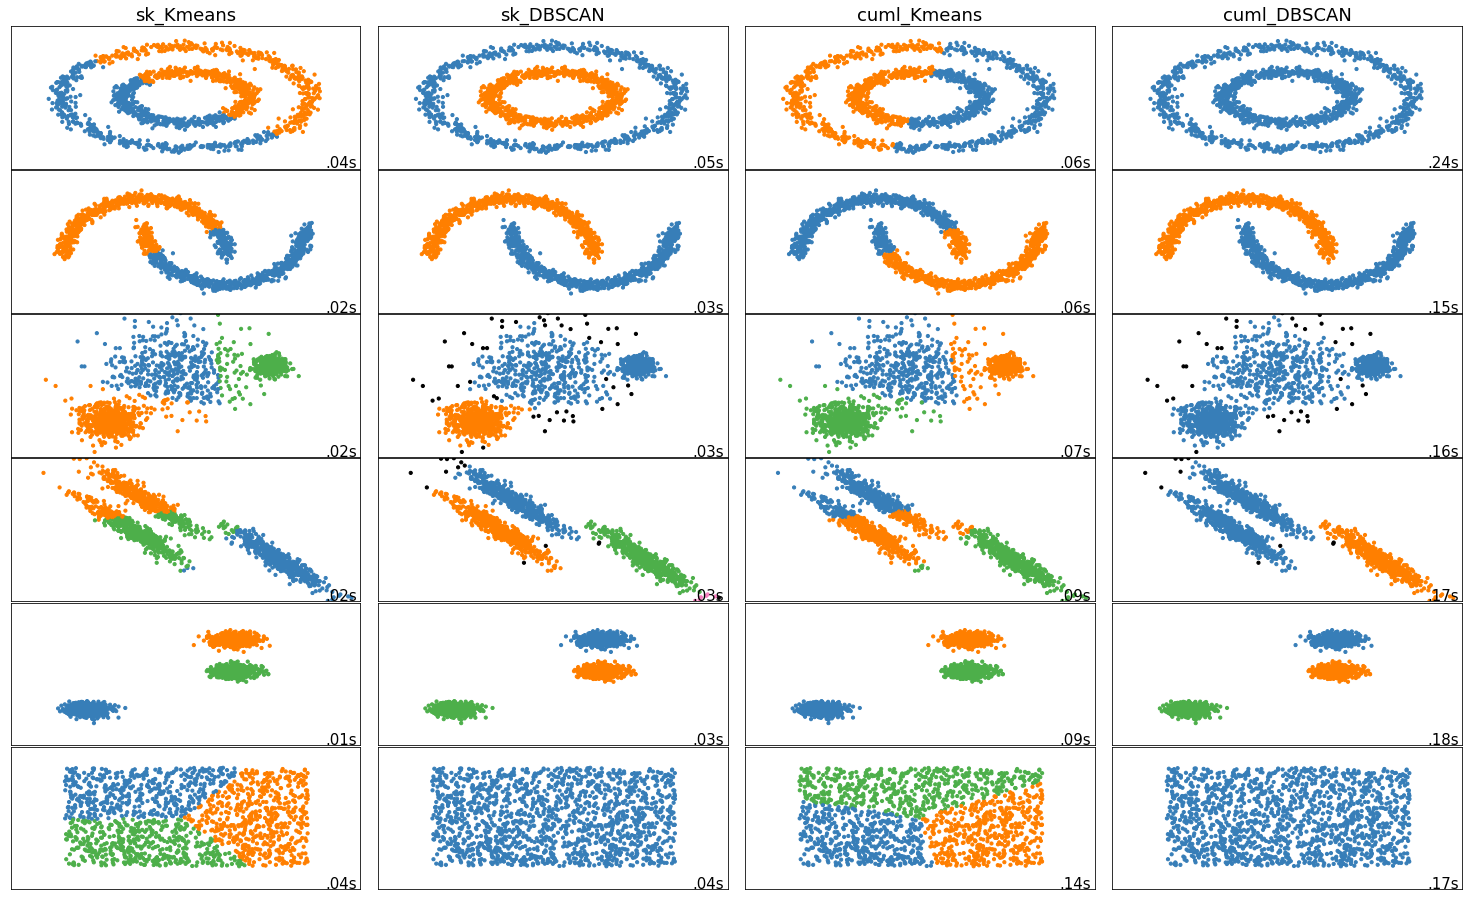

In [13]:
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

patterns,default_base = random_initialize_patterns()

for i_dataset, (dataset, algo_params) in enumerate(patterns):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    # ============
    # Create cluster objects
    # ============
    
    kmeans = cluster.KMeans(n_clusters=params['n_clusters'])
    dbscan = cluster.DBSCAN(eps=params['eps'],min_samples=5, algorithm = "brute")
    cuml_kmeans = cuml.KMeans(n_clusters=params['n_clusters'])
    cuml_dbascan = cuml.DBSCAN(eps=params['eps'],min_samples=5)

    clustering_algorithms = (
        ('sk_Kmeans',kmeans),
        ('sk_DBSCAN', dbscan),
        ('cuml_Kmeans',cuml_kmeans),
        ('cuml_DBSCAN',cuml_dbascan)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        
        y_pred = fit_predict(algorithm,name,X)
        
        t1 = time.time()
        plt.subplot(len(patterns), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()